<div style="text-align: right"> Автор: Логванёва Мария </div>

Подключение библиотек:

In [1]:
from scipy.stats import multivariate_normal, invgamma, norm
from scipy.special import gamma
import numpy as np
import matplotlib.pyplot as plt

Сама функция, которую будем "предсказывать":

In [2]:
# ground truth function
w0_gt = 0.5
w1_gt = 1/3
sigma = 0.1

target_func = lambda x : w0_gt + w1_gt * x + norm.rvs(scale=sigma, size=x.shape)

x_range = (0, 1)

В байесовском выводе выше считалось, что шум наблюдений $\sigma$ известен, но следовало бы навесить априорное распределение и на него. \
В начальной задаче, когда нам была известна $\sigma^{2}$, априорным распределением было многомерное нормальное распределение. Теперь же, когда мы не знаем этот параметр, априорным распределением для него будет [обратное-гамма распределение](https://en.wikipedia.org/wiki/Inverse-gamma_distribution), для параметров весов $\mathbf{w}$ останется многомерное нормальное распределение, а их совместное распределение будет иметь [Нормальное-обратное-гамма распределение](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution), то есть
\begin{align}
    \sigma^{2} &\sim \mathrm{InvGamma}(a_0, b_0), \\
    \mathbf{w}|\sigma &\sim \mathrm{N}(\boldsymbol{\mu_0}, \sigma^{2}\mathbf{\Sigma_0}), \\
    \left(\mathbf{w}, \sigma^{2}\right) &\sim \mathrm{N-Г^{-1}}(\boldsymbol{\mu_0}, \mathbf{\Sigma_0}, a_0, b_0)
\end{align}

Если совместную плотность $(\mathbf{w}, \sigma^2)$ проинтегрируем по $\sigma^2$, то получим плотность весов $\mathbf{w} \in \mathbb{R}^{d}$, которая будет являться двумерным обобщённым распределением Стьюдента ([1](http://www.biostat.umn.edu/~ph7440/pubh7440/BayesianLinearModelGoryDetails.pdf), [2](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution#Marginal_distributions)):
\begin{align}
    \mathbf{w} \sim t_{\nu}\left(\boldsymbol{\mu}, \mathbf{\Sigma}\right),
\end{align}
где плотность обобщённого распределения Стьюдента имеет вид:
\begin{align}
    MVS t_{\nu}(\boldsymbol{\mu}, \mathbf{\Sigma})=\frac{\Gamma\left(\frac{\nu+d}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) (\nu \pi)^{\frac{d}{2}}|\mathbf{\Sigma}|^{\frac{1}{2}}}\left[1+\frac{(\mathbf{w}-\boldsymbol{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{w}-\boldsymbol{\mu})}{\nu}\right]^{-\frac{\nu+d}{2}}
\end{align}
с параметрами $\nu = 2a_0$, $\mathbf{\mu} = \boldsymbol{\mu_0} \in \mathbb{R}^{d}$ и $\mathbf{\Sigma} = \frac{b_0}{a_0}\mathbf{\Sigma_0} \in \mathbb{R}^{d\times d}$.

Так как построить график $(w_0, w_1, \sigma^2)$ мы не можем, рассмотрим проекцию на $(w_0, w_1)$.

In [3]:
class multivariate_t_distribution:
    def __init__(self, mu, Sigma, df, d):
        '''
        Multivariate t-student distribution:
        input:
            x = parameter (d dimensional numpy array or scalar)
            mu = mean (d dimensional numpy array or scalar)
            Sigma = scale matrix (dxd numpy array)
            df = degrees of freedom
            d: dimension
        '''
        self.mu = mu
        self.Sigma = Sigma
        self.df = df
        self.d = d

    def pdf(self, x):
        '''
        Multivariate t-student density:
        output:
            the density of the given element
        input:
            x = parameter (d dimensional numpy array or scalar)
        ''' 
        return np.apply_along_axis(self._pdf, axis=x.ndim - 1, arr=x)
     
    def _pdf(self, x):
        num = gamma(1. * (self.d + self.df)/2)
        denom = (gamma(1. * self.df/2) * pow(self.df * np.pi, 1.* self.d/2) 
                 * pow(np.linalg.det(self.Sigma), 1./2) 
                 * pow(1 + (1./self.df) * np.dot(np.dot((x - self.mu), np.linalg.inv(self.Sigma)), (x - self.mu).T), 1.* (self.d + self.df)/2))
        res = 1. * num / denom
        return res[0]
    
    def rvs(self, M=1):
        '''
        output:
            Produce M samples of d-dimensional multivariate t distribution
        input:
            M = # of samples to produce
        '''
        g = np.tile(np.random.gamma(self.df/2., 2./self.df, M),(self.d, 1)).T
        Z = np.random.multivariate_normal(np.zeros(self.d), self.Sigma, M)
        return self.mu + Z/np.sqrt(g)
    

Запишем априорное для $(w_0, w_1)$ и сгенерируем несколько точек:

In [4]:
# Prior

a_0 = np.array([1.0])
b_0 = np.array([1.0])

lmbd = 0.1
mu_0 = np.zeros(2)
Sigma_0 = lmbd*np.identity(2)

prior = multivariate_t_distribution(mu_0, b_0/a_0*Sigma_0, 2*a_0, 2)

# generate few points (w0, w1) from prior
w_sample = prior.rvs(10)

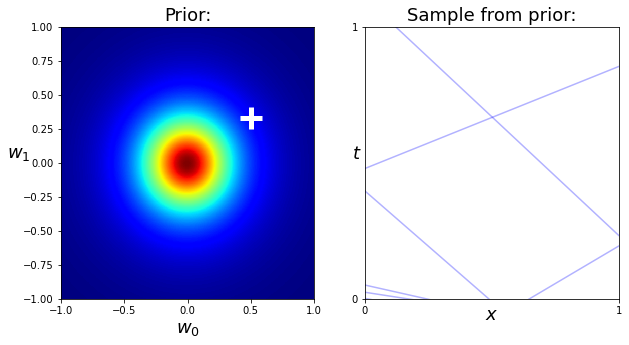

In [5]:
n_grid = 500
w0 = np.linspace(-1, 1, n_grid)
w0_mg, w1_mg = np.meshgrid(w0, w0)
w_mg = np.stack((w0_mg, w1_mg), axis=-1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Prior:', fontsize=18)
plt.xlabel('$w_0$', fontsize=18)
plt.ylabel('$w_1$', fontsize=18, rotation=0)
plt.pcolormesh(w0_mg, w1_mg, prior.pdf(w_mg), cmap='jet', shading='auto')
plt.scatter(w0_gt, w1_gt, marker='+', s=500, color='white', linewidth=5)

plt.subplot(1, 2, 2)
plt.title('Sample from prior:', fontsize=18)
plt.xlabel('$x$', fontsize=18, labelpad=-10)
plt.ylabel('$t$', fontsize=18, labelpad=-5, rotation=0)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 1])
plt.yticks([0, 1])
x_grid = np.linspace(x_range[0], x_range[1], n_grid)
for i in range(w_sample.shape[0]):
    w = w_sample[i]
    t_grid = w[0] + w[1]*x_grid
    plt.plot(x_grid, t_grid, color='blue', alpha=0.3)
    
plt.show()

In [6]:
# gen data (x, t)
n = 1
x = np.random.uniform(x_range[0], x_range[1], size=n)
print('x=', x)
t = np.array([target_func(v) for v in x])
print('t=', t)

x= [0.52486549]
t= [0.6355452]


Правдоподобие имеет всё тот же вид:
\begin{align}
    \mathbf{t} \mid \mathbf{X}, \mathbf{w}, \sigma \sim \mathcal{N}\left(\mathbf{X} \mathbf{w}, \sigma^{2} \mathbf{I}\right)
\end{align}

In [7]:
# Likelihood

# w0, w1 - meshgrids
# x - vector of size n
likelihood = lambda w0, w1, x, t: np.prod([norm.pdf(ti, loc=w0 + xi * w1, scale=sigma) 
                                           for xi, ti in zip(x,t)],
                                          axis=0)

Посчитаем апостериорное распределение. 

Если $\sigma^{2}$ и $\mathbf{w}$ имели такие априорные распределения:
\begin{align}
    \sigma^{2} &\sim \mathrm{InvGamma}(a_0, b_0), \\
    \mathbf{w}|\sigma &\sim \mathrm{N}(\boldsymbol{\mu_0}, \sigma^{2}\mathbf{\Sigma_0}),
\end{align}
то апостериорное будет:
\begin{align}
    \sigma^{2} &\sim \mathrm{InvGamma}(a_n, b_n), \\
    \mathbf{w}|\sigma &\sim \mathrm{N}(\boldsymbol{\mu}_{\mathbf{n}}, \sigma^{2}\mathbf{\Sigma_n}), \\
    \left(\mathbf{w}, \sigma^{2}\right) &\sim \mathrm{N-Г^{-1}}(\boldsymbol{\mu}_{\mathbf{n}}, \mathbf{\Sigma_n}, a_n, b_n), \\
    \mathbf{w} &\sim t_{2 a_n}\left(\boldsymbol{\mu}_{\mathbf{n}}, \frac{b_n}{a_n} \mathbf{\Sigma_n}\right),
\end{align}
где параметры вычисляются так:
\begin{align}
    \mathbf{X} &\in \mathbb{R}^{n\times d}, \\
    a_n &= a_0 + \frac{n}{2}, \\
    b_n &= b_{0}+\frac{1}{2}\left(\boldsymbol{\mu_{0}}^{T} \mathbf{\Sigma_{0}}^{-1} \boldsymbol{\mu_{0}} + \mathbf{t}^{T} \mathbf{t} - \boldsymbol{\mu}_{\mathbf{n}}^{T} \mathbf{\Sigma_{n}}^{-1} \boldsymbol{\mu}_{\mathbf{n}}\right), \\
    \boldsymbol{\mu}_{\mathbf{n}} &= \mathbf{\Sigma_{n}} \left(\mathbf{\Sigma_{0}}^{-1} \mathbf{\mu_{0}} + \mathbf{X}^{T} \mathbf{t}\right), \quad \mathbf{\Sigma_{n}}=\left(\mathbf{\Sigma_{0}}^{-1}+\mathbf{X}^{T} \mathbf{X}\right)^{-1}. 
\end{align}

PS: формулы были взяты из книги K. P. Murphy. Machine Learning: A Probabilistic Perspective. страницы 234 - 236

Функция, которая высчитывает коэффициенты:

In [8]:
def coefCount(mu_0, Sigma_0, a_0, b_0, X, t):
    Sigma_n = np.linalg.inv(np.linalg.inv(Sigma_0) + X.T.dot(X))
    mu_n = Sigma_n.dot(np.linalg.inv(Sigma_0).dot(mu_0) + X.T.dot(t))
    
    a_n = a_0 + np.shape(X)[0]/2
    b_n = b_0 + 0.5*(mu_0.T.dot(np.linalg.inv(Sigma_0)).dot(mu_0) + t.T.dot(t) 
                     - mu_n.T.dot(np.linalg.inv(Sigma_n).dot(mu_n))) 
    return (mu_n, Sigma_n, a_n, b_n)  

In [9]:
# Posterior
X = np.stack([x ** d for d in range(2)], axis=-1)
mu_0, Sigma_0, a_0, b_0 = coefCount(mu_0, Sigma_0, a_0, b_0, X, t)

posterior = multivariate_t_distribution(mu_0, b_0/a_0*Sigma_0, 2*a_0, 2)

Функция, которая строит графики:

In [10]:
def plot_pic(x, t, n, prior, likelihood, posterior, n_grid = 500, fig_size=(14, 14), w_sample_len=10):
    w0 = np.linspace(-1, 1, n_grid)
    w0_mg, w1_mg = np.meshgrid(w0, w0)
    w_mg = np.stack((w0_mg, w1_mg), axis=-1)
    
    f, ax = plt.subplots(2, 2, figsize=fig_size)
    ax[0, 0].set_title('Prior:', fontsize=18)
    ax[0, 0].set_xlabel('$w_0$', fontsize=18)
    ax[0, 0].set_ylabel('$w_1$', fontsize=18, rotation=0)
    ax[0, 0].pcolormesh(w0_mg, w1_mg, prior.pdf(w_mg), cmap='jet', shading='auto')
    ax[0, 0].scatter(w0_gt, w1_gt, marker='+', s=500, color='white', linewidth=5)

    ax[0, 1].set_title('Likelihood:', fontsize=18)
    ax[0, 1].set_xlabel('$w_0$', fontsize=18)
    ax[0, 1].set_ylabel('$w_1$', fontsize=18, rotation=0)
    ax[0, 1].pcolormesh(w0_mg, w1_mg, likelihood(w0_mg, w1_mg, x[-n:], t[-n:]), cmap='jet', shading='auto')
    ax[0, 1].scatter(w0_gt, w1_gt, marker='+', s=500, color='white', linewidth=5)

    ax[1, 0].set_title('Posterior:', fontsize=18)
    ax[1, 0].set_xlabel('$w_0$', fontsize=18)
    ax[1, 0].set_ylabel('$w_1$', fontsize=18, rotation=0)
    ax[1, 0].pcolormesh(w0_mg, w1_mg, posterior.pdf(w_mg), cmap='jet', shading='auto')
    ax[1, 0].scatter(w0_gt, w1_gt, marker='+', s=500, color='white', linewidth=5)

    ax[1, 1].set_title('Sample from posterior:', fontsize=18)
    ax[1, 1].set_xlabel('$x$', fontsize=18, labelpad=-10)
    ax[1, 1].set_ylabel('$t$', fontsize=18, labelpad=-5, rotation=0)
    ax[1, 1].set_xlim(0, 1)
    ax[1, 1].set_ylim(0, 1)
    ax[1, 1].set_xticks([0, 1])
    ax[1, 1].set_yticks([0, 1])
    
    # generate few points (w0, w1) from posterior
    w_sample = posterior.rvs(w_sample_len)
    
    x_grid = np.linspace(x_range[0], x_range[1], n_grid)
    for i in range(w_sample.shape[0]):
        w = w_sample[i]
        t_grid = w[0] + w[1]*x_grid
        ax[1, 1].plot(x_grid, t_grid, color='blue', alpha=0.3)
    ax[1, 1].scatter(x, t, marker='o', s=100, color='red')
    return ax

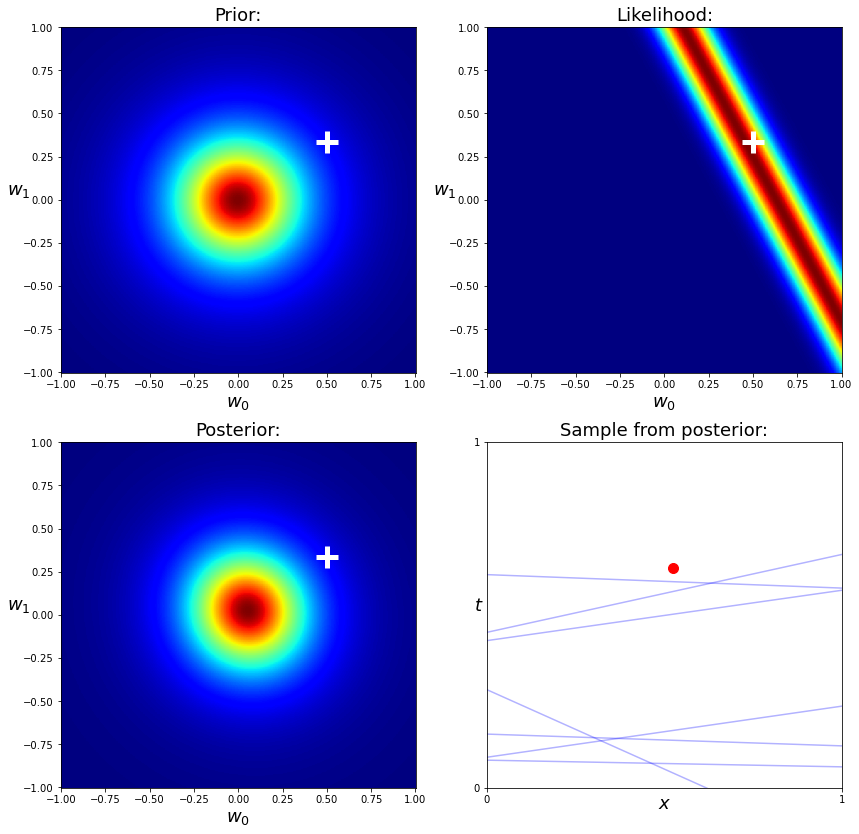

In [11]:
ax = plot_pic(x, t, n, prior, likelihood, posterior, n_grid = 500, fig_size=(14, 14), w_sample_len=10)
plt.show()

In [ ]:
# MOAR DATA

n = 1
x = np.concatenate((x, np.random.uniform(x_range[0], x_range[1], size=n)))
print('x=', x)
t = np.array([target_func(v) for v in x])
print('t=', t)

# prior now is last posterior
prior = posterior

# Posterior
X = np.stack([x ** d for d in range(2)], axis=-1)
mu_0, Sigma_0, a_0, b_0 = coefCount(mu_0, Sigma_0, a_0, b_0, X, t)

posterior = multivariate_t_distribution(mu_0, b_0/a_0*Sigma_0, 2*a_0, 2)

ax = plot_pic(x, t, n, prior, likelihood, posterior, n_grid = 500, fig_size=(14, 14), w_sample_len=10)
plt.show()

x= [0.52486549 0.19405261]
t= [0.61984408 0.63566166]


In [ ]:
# EVEN MOAR DATA

n = 100
x = np.concatenate((x, np.random.uniform(x_range[0], x_range[1], size=n)))
print('x=', x)
t = np.array([target_func(v) for v in x])
print('t=', t)

# prior now is last posterior
prior = posterior

# Posterior
X = np.stack([x ** d for d in range(2)], axis=-1)
mu_0, Sigma_0, a_0, b_0 = coefCount(mu_0, Sigma_0, a_0, b_0, X, t)

posterior = multivariate_t_distribution(mu_0, b_0/a_0*Sigma_0, 2*a_0, 2)

ax = plot_pic(x, t, n, prior, likelihood, posterior, n_grid = 500, fig_size=(14, 14), w_sample_len=10)
plt.show()